In [1]:
#-------- Import Libraries --------#
import torch
import os
import sys
import random
import pickle
import mlflow
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sn
import matplotlib.pyplot as plt
from datetime import date
from sklearn.metrics import matthews_corrcoef
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

In [2]:
#-------- Import Modules from project--------#
import encoding as enc
from model import Net, Net_th, Net_project
import functions as func

In [3]:
#-------- Set Device --------#

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
else:
    print('No GPUs available. Using CPU instead.')
    device = torch.device('cpu')

No GPUs available. Using CPU instead.


In [4]:
#-------- Seeds --------#

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

torch.use_deterministic_algorithms(True)

In [5]:
#-------- Directories --------#

DATADIR = '/data/'
TRAINDIR = '../data/train'
VALIDATIONDIR = '../data/validation'
MATRICES = '/data/Matrices'

In [6]:
#-------- Unzip Train --------#

try:
    if len(os.listdir(TRAINDIR)) != 0:
        print("{} already unzipped.".format(TRAINDIR))
except:
    !unzip ../data/train.zip -d ../data/train

    
#-------- Unzip Validation --------#


try:
    if len(os.listdir(VALIDATIONDIR)) != 0:
        print("{} already unzipped.".format(VALIDATIONDIR))
except:
    !unzip ../data/validation.zip -d ../data/validation
    
print('Train directory:\n\n', '\n'.join(str(p) for p in os.listdir(TRAINDIR)), '\n\n')
print('Validation directory:\n\n','\n'.join(str(p) for p in os.listdir(VALIDATIONDIR)))

../data/train already unzipped.
../data/validation already unzipped.
Train directory:

 P2_labels.npz
P3_input.npz
P4_input.npz
P2_input.npz
__MACOSX
P1_input.npz
P3_labels.npz
P4_labels.npz
P1_labels.npz 


Validation directory:

 P4_input.npz
__MACOSX
P4_labels.npz


In [7]:
#-------- Import Dataset --------#             #TO UPDATE: NO REPEAT P4 AND CONSERVE PARTITION FOR CROSS VAL

data_list = []
target_list = []

import glob
for fp in glob.glob("../data/train/*input.npz"):
    data = np.load(fp)["arr_0"]
    targets = np.load(fp.replace("input", "labels"))["arr_0"]
    data_list.append(data)
    target_list.append(targets)
    
print(len(data_list))
print(len(target_list))

X_train = np.concatenate(data_list[ :-1])
y_train = np.concatenate(target_list[:-1])
nsamples, nx, ny = X_train.shape
print("Training set shape:", nsamples,nx,ny)

X_val = np.concatenate(data_list[-1: ])
y_val = np.concatenate(target_list[-1: ])
nsamples, nx, ny = X_val.shape
print("Val set shape:", nsamples,nx,ny)

p_neg = len(y_train[y_train == 1])/len(y_train)*100
print("Percent positive samples in train:", p_neg)

p_pos = len(y_val[y_val == 1])/len(y_val)*100
print("Percent positive samples in val:", p_pos)

# make the data set into one dataset that can go into dataloader
train_ds = []
for i in range(len(X_train)):
    train_ds.append([np.transpose(X_train[i]), y_train[i]])

val_ds = []
for i in range(len(X_val)):
    val_ds.append([np.transpose(X_val[i]), y_val[i]])

bat_size = 64
print("\nNOTE:\nSetting batch-size to", bat_size)
train_ldr = torch.utils.data.DataLoader(train_ds,batch_size=bat_size, shuffle=True)
val_ldr = torch.utils.data.DataLoader(val_ds,batch_size=bat_size, shuffle=True)

4
4
Training set shape: 4180 420 54
Val set shape: 1526 420 54
Percent positive samples in train: 25.0
Percent positive samples in val: 24.901703800786372

NOTE:
Setting batch-size to 64


In [8]:
#-------- Select the netwrok you would like to use, thesis or hecaton code -------#

CNN = False # ONLY CNN
CNN_RNN = True # CNN + RNN

# Hyperparameters to fine-tune
embedding = "Baseline"
numHN=64
numFilter=100
dropOutRate=0.1

In [9]:
#embedding of data

#create directory to fetch/store embedded
embedding_dir= '../data/embeddedFiles/'
try:
    os.mkdir(embedding_dir)
except:
    pass

#try to fecth if already exist
try:
    with open(embedding_dir+'trainX-{}'.format(embedding)) as f:
        X_train =  pickle.load(f)
    with open(embedding_dir+'testX-{}'.format(embedding)) as f:
        X_test =  pickle.load(f)

#if no prior file, then embbed:
except:
    if embedding == "Baseline":
        pass #this corresponds to original formatting

    elif embedding == "esm-1b":
        X_train = func.extract_sequences(X_train, merge=True).values.tolist()
        X_train = [enc.esm_1b(seq, pooling=False) for seq in X_train]

        X_test = func.extract_sequences(X_test, merge=True).values.tolist()
        X_test = [enc.esm_1b(seq, pooling=False) for seq in X_test]

        #save
        with open(embedding_dir+'trainX-{}'.format(embedding)) as f:
            pickle.dump(X_train, f)
        with open(embedding_dir+'testX-{}'.format(embedding)) as f:
            pickle.dump(X_test, f)

In [10]:
#fixed hyperparameters
features = list(range(54))  #to be redefined
residues = list(range(416))  #to be redefined
num_classes = 1
learning_rate = 0.001
n_features = len(features)
input_size = len(residues)
bat_size = 128
epochs = 100

In [11]:
#data load

X_train = np.concatenate(data_list[ :-1])
y_train = np.concatenate(target_list[:-1])
nsamples, nx, ny = X_train.shape
print("Training set shape:", nsamples,nx,ny)

X_valid = np.concatenate(data_list[-1: ])
y_valid = np.concatenate(target_list[-1: ])
nsamples, nx, ny = X_valid.shape
print("Validation set shape:", nsamples,nx,ny)

# Dataloader
train_ds = []
for i in range(len(X_train)):
    train_ds.append([np.transpose(X_train[i][:,features]), y_train[i]])
val_ds = []
for i in range(len(X_valid)):
    val_ds.append([np.transpose(X_valid[i][:,features]), y_valid[i]])
train_ldr = torch.utils.data.DataLoader(train_ds,batch_size=bat_size, shuffle=True)
val_ldr = torch.utils.data.DataLoader(val_ds,batch_size=bat_size, shuffle=True)

Training set shape: 4180 420 54
Validation set shape: 1526 420 54


In [12]:
###############################
###    CNN Code (hecaton)   ###
###############################

if CNN:
    
    #-------- Define network --------#

    print("Initializing network")

    # Hyperparameters
    input_size = 420
    num_classes = 1
    learning_rate = 0.01
    epochs = 10

    # Initialize network
    net = Net(num_classes=num_classes).to(device)

    # Loss and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)

    #-------- Train network --------#

    print("Training")

    train_acc, train_loss = [], []
    valid_acc, valid_loss = [], []
    losses = []
    val_losses = []

    for epoch in range(epochs):
        cur_loss = 0
        val_loss = 0

        net.train()
        train_preds, train_targs = [], [] 
        for batch_idx, (data, target) in enumerate(train_ldr):
            X_batch =  data.float().detach().requires_grad_(True)
            target_batch = torch.tensor(np.array(target), dtype = torch.float).unsqueeze(1)

            optimizer.zero_grad()
            output = net(X_batch)

            batch_loss = criterion(output, target_batch)
            batch_loss.backward()
            optimizer.step()

            preds = np.round(output.detach().cpu())
            train_targs += list(np.array(target_batch.cpu()))
            train_preds += list(preds.data.numpy().flatten())
            cur_loss += batch_loss.detach()

        losses.append(cur_loss / len(train_ldr.dataset))
        net.eval()

        ### Evaluate validation
        val_preds, val_targs = [], []
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_ldr): ###
                x_batch_val = data.float().detach()
                y_batch_val = target.float().detach().unsqueeze(1)

                output = net(x_batch_val)

                val_batch_loss = criterion(output, y_batch_val)

                preds = np.round(output.detach())
                val_preds += list(preds.data.numpy().flatten()) 
                val_targs += list(np.array(y_batch_val))
                val_loss += val_batch_loss.detach()

            val_losses.append(val_loss / len(val_ldr.dataset))
            print("\nEpoch:", epoch+1)

            train_acc_cur = accuracy_score(train_targs, train_preds)  
            valid_acc_cur = accuracy_score(val_targs, val_preds) 

            train_acc.append(train_acc_cur)
            valid_acc.append(valid_acc_cur)

    
            print("Training loss:", round(losses[-1].item(),3), "Validation loss:", round(val_losses[-1].item(),3), end = "\n")
            print("MCC Train:", round(matthews_corrcoef(train_targs, train_preds),3), "MCC val:", round(matthews_corrcoef(val_targs, val_preds),3) )

    print('\nFinished Training ...')


    #-------- Save results --------#

    results = pd.DataFrame(list(zip( (x[0] for x in val_targs), val_preds)),columns =['target', 'pred'])
    print(results)

    #results.to_csv('results/df_targets_preds.csv'.format(str(date.today())), index=False)


    #-------- Performance Evaluation --------#
    # The results change every time we train, we should check why (maybe we missed something or did wrong with the seeds?)

    print("AUC: ", roc_auc_score(results['target'], results['pred']))
    print("MCC: ", matthews_corrcoef(results['target'], results['pred']))

    confusion_matrix = pd.crosstab(results['target'], results['pred'], rownames=['Actual'], colnames=['Predicted'])
    sn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
    plt.show()



Training set shape: 4180 420 54
Validation set shape: 1526 420 54
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Early stopping



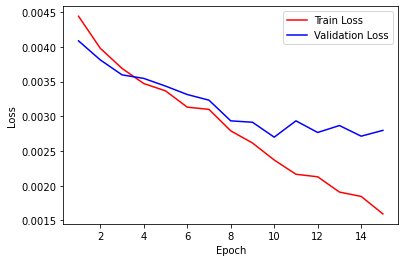

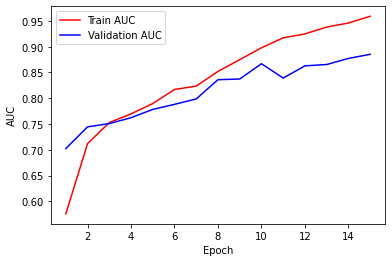

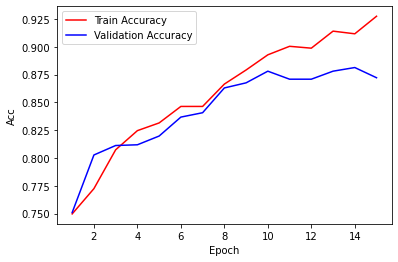

      target  pred
0          0     0
1          1     1
2          0     0
3          0     0
4          1     0
...      ...   ...
1521       0     0
1522       0     0
1523       0     0
1524       0     0
1525       0     0

[1526 rows x 2 columns]
AUC:  0.8032263249747406
MCC:  0.643479870211756


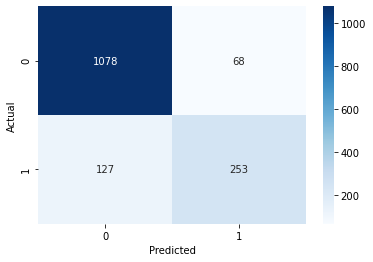

195


In [13]:

###############################
###    CNN+RNN (thesis)     ###
###############################

if CNN_RNN:
    
    #-------- Initials --------#

    # All features
    features = list(range(54))
    residues = list(range(416))
    input_size = len(residues)
    num_classes = 1
    learning_rate = 0.001
    bat_size = 128
    epochs = 100
    n_features = len(features)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate,
                           weight_decay=0.0005,
                           amsgrad=True,)
    

    #-------- Train --------#
    X_train = np.concatenate(data_list[ :-1])
    y_train = np.concatenate(target_list[:-1])
    nsamples, nx, ny = X_train.shape
    print("Training set shape:", nsamples,nx,ny)

    X_valid = np.concatenate(data_list[-1: ])
    y_valid = np.concatenate(target_list[-1: ])
    nsamples, nx, ny = X_valid.shape
    print("Validation set shape:", nsamples,nx,ny)

    # Dataloader
    train_ds = []
    for i in range(len(X_train)):
        train_ds.append([np.transpose(X_train[i][:,features]), y_train[i]])
    val_ds = []
    for i in range(len(X_valid)):
        val_ds.append([np.transpose(X_valid[i][:,features]), y_valid[i]])
    train_ldr = torch.utils.data.DataLoader(train_ds,batch_size=bat_size, shuffle=True)
    val_ldr = torch.utils.data.DataLoader(val_ds,batch_size=bat_size, shuffle=True)

    # Initialize network
    net = Net_th(num_classes=num_classes, n_features=n_features).to(device)

    train_acc, train_losses, train_auc, valid_acc, valid_losses, valid_auc, val_preds, val_targs = func.train_project(net, optimizer, train_ldr, val_ldr, [], X_valid, epochs, criterion)


    #-------- Performance --------#
    epoch = np.arange(1,len(train_losses)+1)
    plt.figure()
    plt.plot(epoch, train_losses, 'r', epoch, valid_losses, 'b')
    plt.legend(['Train Loss','Validation Loss'])
    plt.xlabel('Epoch'), plt.ylabel('Loss')

    epoch = np.arange(1,len(train_auc)+1)
    plt.figure()
    plt.plot(epoch, train_auc, 'r', epoch, valid_auc, 'b')
    plt.legend(['Train AUC','Validation AUC'])
    plt.xlabel('Epoch'), plt.ylabel('AUC')

    epoch = np.arange(1,len(train_acc)+1)
    plt.figure()
    plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
    plt.legend(['Train Accuracy','Validation Accuracy'])
    plt.xlabel('Epoch'), plt.ylabel('Acc')
    plt.show()

    
    #-------- Save results --------#

    results = pd.DataFrame(list(zip( (int(x) for x in val_targs), (int(x) for x in val_preds))),columns =['target', 'pred'])
    print(results)

    #results.to_csv('results/df_targets_preds_th.csv'.format(str(date.today())), index=False

    
    #-------- Performance Evaluation --------#
    # The results change every time we train, we should check why (maybe we missed something or did wrong with the seeds?)

    print("AUC: ", roc_auc_score(results['target'], results['pred']))
    print("MCC: ", matthews_corrcoef(results['target'], results['pred']))

    confusion_matrix = pd.crosstab(results['target'], results['pred'], rownames=['Actual'], colnames=['Predicted'])
    sn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
    plt.show()

    print( len([i for i, (a, b) in enumerate(zip(results['pred'], results['target'])) if a != b]))

In [ ]:
#storing values
with mlflow.start:run():
    mlflow.log_param('embedding', embedding) 
    mlflow.log_param('Hidden Neurons', numHN)
    mlflow.log_param('filters CNN', numFilter)
    mlflow.log_param('Dropout rate', dropOutRate)
    mlflow.log_metric('AUC', AUC)
    mlflow.log_metric('MCC', MCC)
    #ADD ARTIFACTS (PLOTS)